# Analysis of COVID-19 Impact On (BEACH)  Stocks  and Price Prediction 

### Introduction:
We realize that the [COVID-19](https://en.wikipedia.org/wiki/Coronavirus_disease_2019) has flipped around the economy. Companies in the travel and entertainment sectors, so-called BEACH stocks- were the absolute hardest hit. These stocks have seen more than $332 billion in esteem vanish during the months of Feb-Mar 2020 [source](https://markets.businessinsider.com/news/stocks/covid-19-downturn-beach-stocks-1029032907#)

Investment firms, hedge funds and even individuals have been using financial models to better understand market behavior and make profitable investments and trades. A wealth of information is available in the form of historical stock prices and company performance data, suitable for machine learning algorithms to process.

### Objectiv:
The objective of this project is :

1-	To quantify, compare, and visualize the impact of COVID-19 on the US stock market in the travel and entertainment sectors. The stocks are considered from 2 Jan of(2019 and 2020) to May 31 (2019 and 2020), I've slected this period becuse the lockdown started in USA on March 19 2020 and As of 12 April, nearly 300 million people, or about 90 per cent of the population, are under some form of lockdown in the United States [source](https://www.businessinsider.com/us-map-stay-at-home-orders-lockdowns-2020-3).

2-	To build a stock price predictor that takes daily trading data over a certain date range as input, and outputs projected estimates for given query dates. the inputs will contain multiple metrics, such as opening price (Open), highest price the stock traded at (High), how many stocks were traded (Volume) (Adjusted Close); The system only will predict the Adjusted Close price.


### Data:
Data has been accessed from :
- Yahoo Finance using pandas_datareader library.
- USA COVID-19 from https://raw.githubusercontent.com

## Table of Contents

 1. Importing Modules
 2. Data download and Exploration
 
 Part(1) Analysis of COVID-19 Impact On (BEACH)  Stocks
 
 3. Visualizing The Data
 4. Basic Financial Analysis
 
Part(2) price prediction using Long Short Term Memory (LSTM) 
 1. Data Visualizing 
 2. Data Preprocessing
 3. Data Modeling 



## 1) Importing Modules 
Load packages

In [1]:

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import yfinance as yf
from datetime import date, timedelta, datetime
import math
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


import plotly.graph_objs as go # this is used for interactivate plot
import plotly.express as px
import requests

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Dropout
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) # ignore tf warning


In [2]:
# Create the business day, which is used to convert the day index to stock trading days
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
B_DAY = CustomBusinessDay(calendar=USFederalHolidayCalendar()) # business day

## 2) Data download and Exploration

2.1 Getting The Data From raw.githubusercontent.com<br>
    -USA COVID-19 confirmed cases<br>
2.2 Getting The Data From Yahoo Finance for 2019 and 2020
    -Booking Stock (Ticker: BKNG on the NASDAQ)- Booking <br>
    -Expedia Stock (Ticker: EXPE on the NASDAQ) Booking
    -Netflix Stock (Ticker: NFLX on the NASDAQ) Media/Entertainment <br>
    -Six Flags (Ticker: SIX on the NASDAQ) Entertainment & Live Events	
    -United Airlines Stock (Ticker: UAL on the NASDAQ)- Airlines <br>
    -Royal Caribbean Cruises (Ticker: RCL on the NASDAQ) - Cruise & Casino <br>
    -Marriott International stock (Ticker: MAR on the NASDAQ) - Hotels and Resorts



In [3]:
#Getting The Data From raw.githubusercontent.com - USA COVID-19 confirmed cases
for filename in ['time_series_covid19_confirmed_global.csv']:
    print(f'Downloading {filename}')
    url = f'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/{filename}'
    myfile = requests.get(url)
    open(filename, 'wb').write(myfile.content)
    
confirmed_global_df = pd.read_csv('time_series_covid19_confirmed_global.csv')
confirmed_global_df["Country/Region"].replace({'US': 'United States'}, inplace=True)

In [4]:
country_main = 'United States'
confirmed_global_df = confirmed_global_df[confirmed_global_df['Country/Region'] == country_main].reset_index(drop=True)
confirmed_global_df

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,10/6/20,10/7/20,10/8/20,10/9/20,10/10/20,10/11/20,10/12/20,10/13/20,10/14/20,10/15/20
0,NaN,United States,40.0,-100.0,1,1,2,2,5,5,...,7499341,7549682,7605873,7663293,7717932,7762546,7804199,7856605,7916099,7979709


In [5]:
def _convert_date_str(df):
    """
    convert covid19 date to string
    Params:
        df: stock to pull data
    Return:
        none
    """
    try:
        df.columns = list(df.columns[:4]) + [datetime.strptime(d, "%m/%d/%y").date().strftime("%Y-%m-%d") for d in df.columns[4:]]
    except:
        print('_convert_date_str failed with %y, try %Y')
        df.columns = list(df.columns[:4]) + [datetime.strptime(d, "%m/%d/%Y").date().strftime("%Y-%m-%d") for d in df.columns[4:]]

_convert_date_str(confirmed_global_df)
confirmed_global_df

,Province/State,Country/Region,Lat,Long,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,...,2020-10-06,2020-10-07,2020-10-08,2020-10-09,2020-10-10,2020-10-11,2020-10-12,2020-10-13,2020-10-14,2020-10-15
0,NaN,United States,40.0,-100.0,1,1,2,2,5,5,...,7499341,7549682,7605873,7663293,7717932,7762546,7804199,7856605,7916099,7979709


In [6]:
# set fileds and group the data by date
df_confirmed = confirmed_global_df.melt(
    id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], value_vars=confirmed_global_df.columns[4:], var_name='Date', value_name='ConfirmedCases')
df_covid = df_confirmed.groupby(["Date", "Country/Region"])[['Date', 'Country/Region', 'ConfirmedCases']].sum().reset_index()
df_covid.columns = ['Date', 'Country', 'Confirmed']
# explore the data
df_covid

,Date,Country,Confirmed
0,2020-01-22,United States,1
1,2020-01-23,United States,1
2,2020-01-24,United States,2
3,2020-01-25,United States,2
4,2020-01-26,United States,5
...,...,...,...
263,2020-10-11,United States,7762546
264,2020-10-12,United States,7804199
265,2020-10-13,United States,7856605
266,2020-10-14,United States,7916099


In [244]:
# match the data to be same as start and end of stock dataframe 
split_date = '2020-05-31'
df_covid = df_covid.loc[df_covid['Date'] <= split_date]
df_covid['Date']= pd.to_datetime(df_covid['Date'])
df_covid.sort_values('Date', inplace=True)

In [245]:
df_covid

,Date,Country,Confirmed
0,2020-01-22,United States,1
1,2020-01-23,United States,1
2,2020-01-24,United States,2
3,2020-01-25,United States,2
4,2020-01-26,United States,5
...,...,...,...
126,2020-05-27,United States,1706331
127,2020-05-28,United States,1729279
128,2020-05-29,United States,1753630
129,2020-05-30,United States,1777473


In [251]:
df_covid.describe()

,Confirmed
count,1.310000e+02
mean,5.057217e+05
std,6.164102e+05
min,1.000000e+00
25%,1.600000e+01
50%,1.051790e+05
75%,1.033262e+06
max,1.796645e+06


In [252]:
# get the date of max number of confiremd covid19 cases 
df_covid[df_covid['Confirmed']==df_covid.max()['Confirmed']].head(1)

,Date,Country,Confirmed
130,2020-05-31,United States,1796645


In [253]:
# Get The date of first covid-19 case reported in USA 
df_covid[df_covid['Confirmed']==1].head(1)

,Date,Country,Confirmed
0,2020-01-22,United States,1


In [254]:
# get the date when the cases when it reach 25% in USA reported cases, this will be used later in the analysis 
perc_25 = np.percentile(df_covid.Confirmed, 25)
df_covid[df_covid['Confirmed']== perc_25].head(1)

,Date,Country,Confirmed
30,2020-02-21,United States,16


In [255]:
# get the date when the cases when reach 50% in USA reported cases, this will be used later in the analysis 
perc_50 = np.percentile(df_covid.Confirmed, 50)
df_covid[df_covid['Confirmed']== perc_50].head(1)

,Date,Country,Confirmed
65,2020-03-27,United States,105179


In [256]:
# get the date when the cases when reach 75% in USA reported cases, this will be used later in the analysis 
perc_70 = np.percentile(df_covid.Confirmed, 70)
round(perc_70)
df_covid[df_covid['Confirmed']== perc_70].head(1)

,Date,Country,Confirmed
91,2020-04-22,United States,845594


In [257]:
def download_stock_to_df(symbol, start, end):
    """
    Get current stocks data from yahoo fiance and save to dataframe

    Params:
        symbol: stock to pull data
        start: start date of pulled data
        end: end date of pulled data

    Return:
        dataframe of stock within specified date range
    """
    df_stock=yf.download(symbol,start,end,progress=False)
    df_stock.reset_index(level=0, inplace=True)
    return df_stock

In [15]:
def set_date_df(df):
    """
    Set date as index in dataframe
    calculate return 
    Params:
        df: stock to pull data
    Return:
        dataframe of stock within specified date range and reutern value 
    """
    df_stock = df.copy(deep=True)
    df_stock['Date']= pd.to_datetime(df_stock['Date'])
    df_stock.sort_values('Date', inplace=True)
#    df_stock = df_stock.set_index('Date')
#We can use pandas pct_change() method on the Close column to create a column representing this return value
    df_stock['Return'] = df_stock['Close'].pct_change()
    return df_stock


In [16]:
# read booking stock for 2019
booking_2019 = download_stock_to_df('BKNG', '2019-01-02', '2019-05-31')
booking_2019 = set_date_df(booking_2019)
booking_2019.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Return
0,2019-01-02,1691.250000,1736.770020,1690.839966,1721.699951,1721.699951,312600,NaN
1,2019-01-03,1704.650024,1712.680054,1657.979980,1663.119995,1663.119995,445200,-0.034024
2,2019-01-04,1686.119995,1737.079956,1678.619995,1717.550049,1717.550049,541000,0.032728
3,2019-01-07,1721.739990,1731.400024,1703.599976,1711.819946,1711.819946,334800,-0.003336
4,2019-01-08,1730.040039,1755.989990,1681.150024,1686.920044,1686.920044,652400,-0.014546


In [17]:
# read booking stock for 2020 
booking_2020 = download_stock_to_df('BKNG', '2020-01-02', '2020-05-31')
booking_2020 = set_date_df(booking_2020)
booking_2020.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Return
0,2020-01-02,2068.399902,2077.409912,2053.219971,2074.580078,2074.580078,329000,NaN
1,2020-01-03,2042.469971,2067.689941,2035.000000,2065.479980,2065.479980,294000,-0.004386
2,2020-01-06,2050.000000,2059.790039,2035.000000,2047.400024,2047.400024,384000,-0.008753
3,2020-01-07,2047.390015,2072.830078,2038.540039,2068.050049,2068.050049,345300,0.010086
4,2020-01-08,2066.840088,2088.659912,2057.139893,2062.899902,2062.899902,325800,-0.002490


In [18]:
#I have include the stock history for Booking stock to prdeict the price
booking_hist = download_stock_to_df('BKNG', '2000-01-01', '2020-10-05')
booking_hist.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1999-12-31,282.375,296.2500,280.875,284.250,284.250,410100
1,2000-01-03,315.000,318.0000,288.000,307.500,307.500,847700
2,2000-01-04,308.250,343.5000,307.500,324.000,324.000,972700
3,2000-01-05,331.500,385.3125,327.750,359.625,359.625,1605400
4,2000-01-06,368.250,384.7500,326.250,345.000,345.000,1175200


In [236]:
# read Expedia stock for 2019
Expedia_2019 = download_stock_to_df('EXPE', '2019-01-02', '2019-05-31')
Expedia_2019 = set_date_df(Expedia_2019)
Expedia_2019.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Return
0,2019-01-02,110.400002,113.000000,110.199997,111.980003,110.296707,1235100,NaN
1,2019-01-03,111.169998,112.029999,108.110001,108.519997,106.888710,1645100,-0.030898
2,2019-01-04,111.040001,114.000000,110.559998,113.089996,111.390015,2289200,0.042112
3,2019-01-07,112.919998,115.250000,112.379997,114.559998,112.837914,1232100,0.012999
4,2019-01-08,115.440002,117.250000,114.410004,116.970001,115.211693,1777200,0.021037


In [237]:
# read Expedia stock for 2019
Expedia_2020 = download_stock_to_df('EXPE', '2020-01-02', '2020-05-31')
Expedia_2020 = set_date_df(Expedia_2020)
Expedia_2020.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Return
0,2020-01-02,108.870003,111.150002,108.779999,110.980003,110.569191,3481200,NaN
1,2020-01-03,109.589996,110.440002,108.349998,109.129997,108.726028,2027100,-0.016670
2,2020-01-06,108.160004,109.070000,107.800003,108.739998,108.337479,2218300,-0.003574
3,2020-01-07,108.680000,110.300003,108.500000,110.019997,109.612740,1813100,0.011771
4,2020-01-08,110.199997,110.980003,108.059998,108.620003,108.217926,1990000,-0.012725


In [19]:
#I've included Netflix because it is kind of a meida entertainment company. So, I wanted to compare 
# its results with the hardest-hit companies as people were social distancing due to sudden rise of COVID-19..
nflx_2019 = download_stock_to_df('NFLX', '2019-01-02', '2019-05-31')
nflx_2019 = set_date_df(nflx_2019)
nflx_2019.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Return
0,2019-01-02,259.279999,269.750000,256.579987,267.660004,267.660004,11679500,NaN
1,2019-01-03,270.200012,275.790009,264.429993,271.200012,271.200012,14969600,0.013226
2,2019-01-04,281.880005,297.799988,278.540009,297.570007,297.570007,19330100,0.097234
3,2019-01-07,302.100006,316.799988,301.649994,315.339996,315.339996,18620100,0.059717
4,2019-01-08,319.980011,320.589996,308.010010,320.269989,320.269989,15359200,0.015634


In [20]:
# read netflix stock for  2020 
nflx_2020 = download_stock_to_df('NFLX', '2020-01-02', '2020-05-31')
nflx_2020 = set_date_df(nflx_2020)
nflx_2020.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Return
0,2020-01-02,326.100006,329.980011,324.779999,329.809998,329.809998,4485800,NaN
1,2020-01-03,326.779999,329.859985,325.529999,325.899994,325.899994,3806900,-0.011855
2,2020-01-06,323.119995,336.359985,321.200012,335.829987,335.829987,5663100,0.030469
3,2020-01-07,336.470001,336.700012,330.299988,330.750000,330.750000,4703200,-0.015127
4,2020-01-08,331.489990,342.700012,331.049988,339.260010,339.260010,7104500,0.025729


In [232]:
#six flags 2019
six_2019 = download_stock_to_df('SIX', '2019-01-02', '2019-05-31')
six_2019 = set_date_df(six_2019)
six_2019.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Return
0,2019-01-02,54.880001,56.310001,54.400002,56.029999,52.150455,768100,NaN
1,2019-01-03,55.419998,56.770000,54.680000,55.930000,52.057381,455500,-0.001785
2,2019-01-04,56.939999,57.939999,56.540001,57.799999,53.797901,795700,0.033435
3,2019-01-07,58.200001,59.759998,57.450001,59.060001,54.970661,1116700,0.021799
4,2019-01-08,59.849998,60.340000,59.080002,60.220001,56.050343,702700,0.019641


In [233]:
# Six Flags 2020
six_2020 = download_stock_to_df('SIX', '2020-01-02', '2020-05-31')
six_2020 = set_date_df(six_2020)
six_2020.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Return
0,2020-01-02,44.369999,45.060001,43.799999,45.060001,44.611912,1773900,NaN
1,2020-01-03,44.709999,45.330002,44.419998,45.259998,44.809917,799000,0.004438
2,2020-01-06,44.380001,44.990002,43.869999,44.369999,43.928768,1264500,-0.019664
3,2020-01-07,44.450001,45.279999,44.419998,44.419998,43.978271,1233400,0.001127
4,2020-01-08,44.230000,44.810001,43.250000,43.560001,43.126827,1875900,-0.019361


In [23]:
# read united stock for 2019 
united_2019 = download_stock_to_df('UAL', '2019-01-02', '2019-05-31')
united_2019 = set_date_df(united_2019)
united_2019.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Return
0,2019-01-02,81.690002,84.290001,81.410004,84.180000,84.180000,2973400,NaN
1,2019-01-03,83.260002,83.260002,78.379997,80.000000,80.000000,6426200,-0.049656
2,2019-01-04,80.879997,83.949997,80.769997,82.680000,82.680000,3808300,0.033500
3,2019-01-07,82.570000,83.919998,81.449997,83.230003,83.230003,2653000,0.006652
4,2019-01-08,83.300003,84.620003,81.889999,82.379997,82.379997,3910000,-0.010213


In [24]:
# read united stock for  2020
united_2020 = download_stock_to_df('UAL', '2020-01-02', '2020-05-31')
united_2020 = set_date_df(united_2020)
united_2020.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Return
0,2020-01-02,89.570000,90.570000,89.110001,89.739998,89.739998,2769800,NaN
1,2020-01-03,86.800003,88.160004,86.260002,87.900002,87.900002,3562900,-0.020504
2,2020-01-06,86.720001,88.070000,86.650002,87.699997,87.699997,2652700,-0.002275
3,2020-01-07,87.410004,88.160004,86.739998,86.769997,86.769997,2581300,-0.010604
4,2020-01-08,86.900002,88.449997,86.300003,87.300003,87.300003,4152500,0.006108


In [25]:
# read royal stock for 2019 
royal_2019 = download_stock_to_df('RCL', '2019-01-02', '2019-05-31')
royal_2019 = set_date_df(royal_2019)
royal_2019.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Return
0,2019-01-02,96.400002,98.510002,95.949997,97.790001,94.466072,1352200,NaN
1,2019-01-03,96.699997,97.309998,91.879997,92.550003,89.404190,2807800,-0.053584
2,2019-01-04,94.800003,99.919998,94.500000,98.760002,95.403107,2261400,0.067099
3,2019-01-07,99.669998,102.709999,98.809998,101.830002,98.368744,2150300,0.031085
4,2019-01-08,103.739998,104.809998,102.529999,103.930000,100.397377,1882300,0.020623


In [26]:
# read royal stock for 2020
royal_2020 = download_stock_to_df('RCL', '2020-01-02', '2020-05-31')
royal_2020 = set_date_df(royal_2020)
royal_2020.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Return
0,2020-01-02,134.550003,134.800003,133.470001,134.649994,133.326569,1014400,NaN
1,2020-01-03,132.789993,133.619995,131.809998,133.490005,132.177979,1229400,-0.008615
2,2020-01-06,131.589996,131.869995,130.389999,131.630005,130.336258,1518000,-0.013934
3,2020-01-07,131.080002,132.100006,130.440002,130.440002,129.157959,1211400,-0.009041
4,2020-01-08,130.350006,132.710007,130.020004,132.220001,130.920456,1429600,0.013646


In [27]:
# read marriott stock for 2019 
marriott_2019 = download_stock_to_df('MAR', '2019-01-02', '2019-05-31')
marriott_2019 = set_date_df(marriott_2019)
marriott_2019.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Return
0,2019-01-02,106.720001,108.589996,105.290001,107.459999,105.518723,1802100,NaN
1,2019-01-03,106.349998,107.000000,101.570000,101.739998,99.902061,3344300,-0.053229
2,2019-01-04,103.139999,107.919998,103.139999,107.809998,105.862404,3045300,0.059662
3,2019-01-07,107.410004,108.879997,105.949997,108.010002,106.058792,1529000,0.001855
4,2019-01-08,108.860001,110.070000,107.820000,109.760002,107.777176,1631100,0.016202


In [28]:
# read marriott stock for 2020
marriott_2020 = download_stock_to_df('MAR', '2020-01-02', '2020-05-31')
marriott_2020 = set_date_df(marriott_2020)
marriott_2020.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Return
0,2020-01-02,151.500000,152.600006,151.029999,151.490005,150.884995,1905600,NaN
1,2020-01-03,149.190002,150.020004,148.740005,149.270004,148.673859,2116900,-0.014654
2,2020-01-06,147.899994,147.990005,146.210007,147.339996,146.751572,2178200,-0.012930
3,2020-01-07,146.740005,147.220001,144.679993,144.940002,144.361160,2073200,-0.016289
4,2020-01-08,145.130005,147.619995,144.720001,146.729996,146.143997,1412800,0.012350


In [114]:
#for more data understanding let's look at the  data types
booking_hist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5223 entries, 0 to 5222
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       5223 non-null   datetime64[ns]
 1   Open       5223 non-null   float64       
 2   High       5223 non-null   float64       
 3   Low        5223 non-null   float64       
 4   Close      5223 non-null   float64       
 5   Adj Close  5223 non-null   float64       
 6   Volume     5223 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 285.8 KB


In [116]:
booking_hist.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5223.000000,5223.000000,5223.000000,5223.000000,5223.000000,5.223000e+03
mean,656.552976,663.909173,648.807562,656.408153,656.408153,8.127243e+05
std,704.179392,710.527483,697.726180,704.099879,704.099879,7.860427e+05
min,6.600000,7.140000,6.300000,6.600000,6.600000,3.690000e+04
25%,31.930000,32.674999,30.920000,31.799999,31.799999,3.887500e+05
50%,324.829987,334.125000,312.750000,323.799988,323.799988,6.113000e+05
75%,1248.895020,1262.000000,1236.340027,1248.679993,1248.679993,9.870500e+05
max,2210.929932,2228.989990,2174.070068,2206.090088,2206.090088,1.583610e+07


## 3) Data Analysis and Visualization 
#### To Analys the impact of COVID-19 on BEACH sector

There are multiple variables in the dataset – date, open, high, low, last, close, volum, 

The columns Open and Close represent the starting and final price at which the stock is traded on a particular day.
High, Low and Last represent the maximum, minimum, and last price of the share for the day.

compare the Adj price for the selected stocks in 2019 and 2020 at the selected period of time:

In [262]:
print("Min Adj price for Booking in 2019 vs 2020:" , booking_2019['Adj Close'].min(), ':', booking_2020['Adj Close'].min())
decline = ((booking_2019['Adj Close'].mean() - booking_2020['Adj Close'].mean())/booking_2019['Adj Close'].mean())*100
print("The Decline in the Adj price for Booking in 2019 vs 2020:" , decline)

Min Adj price for Booking in 2019 vs 2020: 1649.489990234375 : 1152.239990234375
The Decline in the Adj price for Booking in 2019 vs 2020: 8.785021105507077


In [272]:
print("Min Adj price for Expedia in 2019 vs 2020:" , Expedia_2019['Adj Close'].min(), ':', Expedia_2020['Adj Close'].min())
decline = ((Expedia_2019['Adj Close'].mean() - Expedia_2020['Adj Close'].mean())/Expedia_2019['Adj Close'].mean())*100
print("The Decline in the Adj price for Expedia in 2019 vs 2020:" , decline)

Min Adj price for Expedia in 2019 vs 2020: 106.88871002197266 : 45.650001525878906
The Decline in the Adj price for Expedia in 2019 vs 2020: 30.048218666261768


In [273]:
print("Min Adj price for NetFlix in 2019 vs 2020:" , nflx_2019['Adj Close'].min() ,':', nflx_2020['Adj Close'].min())
decline = ((nflx_2019['Adj Close'].mean() - nflx_2020['Adj Close'].mean())/nflx_2019['Adj Close'].mean())*100
print("The Decline in the Adj price for Netflix in 2019 vs 2020:" , decline)

Min Adj price for NetFlix in 2019 vs 2020: 267.6600036621094 : 298.8399963378906
The Decline in the Adj price for Netflix in 2019 vs 2020: -7.390341922057356


In [274]:
print("Min Adj price for Six Flags in 2019 vs 2020:" , six_2019['Adj Close'].min() ,':', six_2020['Adj Close'].min())
decline = ((six_2019['Adj Close'].mean() - six_2020['Adj Close'].mean())/six_2019['Adj Close'].mean())*100
print("The Decline in the Adj price for Six Flags in 2019 vs 2020:" , decline)

Min Adj price for Six Flags in 2019 vs 2020: 44.07891845703125 : 10.359999656677246
The Decline in the Adj price for Six Flags in 2019 vs 2020: 51.24767204957254


In [275]:
print("Min Adj price for United Air in 2019 vs 2020:" , united_2019['Adj Close'].min() ,':', united_2020['Adj Close'].min())
decline = ((united_2019['Adj Close'].mean() - united_2020['Adj Close'].mean())/united_2019['Adj Close'].mean())*100
print("The Decline in the Adj price for United Air in 2019 vs 2020:" , decline)

Min Adj price for United Air in 2019 vs 2020: 77.48999786376953 : 19.920000076293945
The Decline in the Adj price for United Air in 2019 vs 2020: 40.60265247023829


In [276]:
print("Min Adj price for Royal in 2019 vs 2020:" ,royal_2019['Adj Close'].min() ,':', royal_2020['Adj Close'].min())
decline = ((royal_2019['Adj Close'].mean() - royal_2020['Adj Close'].mean())/royal_2019['Adj Close'].mean())*100
print("The Decline in the Adj price for Royal in 2019 vs 2020:" , decline)

Min Adj price for Royal in 2019 vs 2020: 89.40419006347656 : 22.329999923706055
The Decline in the Adj price for Royal in 2019 vs 2020: 38.52690967072977


In [277]:
print("Min Adj price for Marriott in 2019 vs 2020:" , marriott_2019['Adj Close'].min() ,':', marriott_2020['Adj Close'].min())
decline = ((marriott_2019['Adj Close'].mean() - marriott_2020['Adj Close'].mean())/marriott_2019['Adj Close'].mean())*100
print("The Decline in the Adj price for Marriott in 2019 vs 2020:" , decline)

Min Adj price for Marriott in 2019 vs 2020: 99.90206146240234 : 59.08000183105469
The Decline in the Adj price for Marriott in 2019 vs 2020: 11.54468664215102


## 3) Visualizing The Data 
### To Analys the impact of COVID-19 on BEACH sector

### a) Comparing each company percent change between 2019 and 2020

In [225]:
monthDay_df = pd.DataFrame(columns=['MonthDay'])
monthDay_df['MonthDay'] = booking_2019['Date'].apply(lambda x: x.strftime("%B %d") if pd.notnull(x) else '')
monthDay_df

,MonthDay
0,January 02
1,January 03
2,January 04
3,January 07
4,January 08
...,...
98,May 23
99,May 24
100,May 28
101,May 29


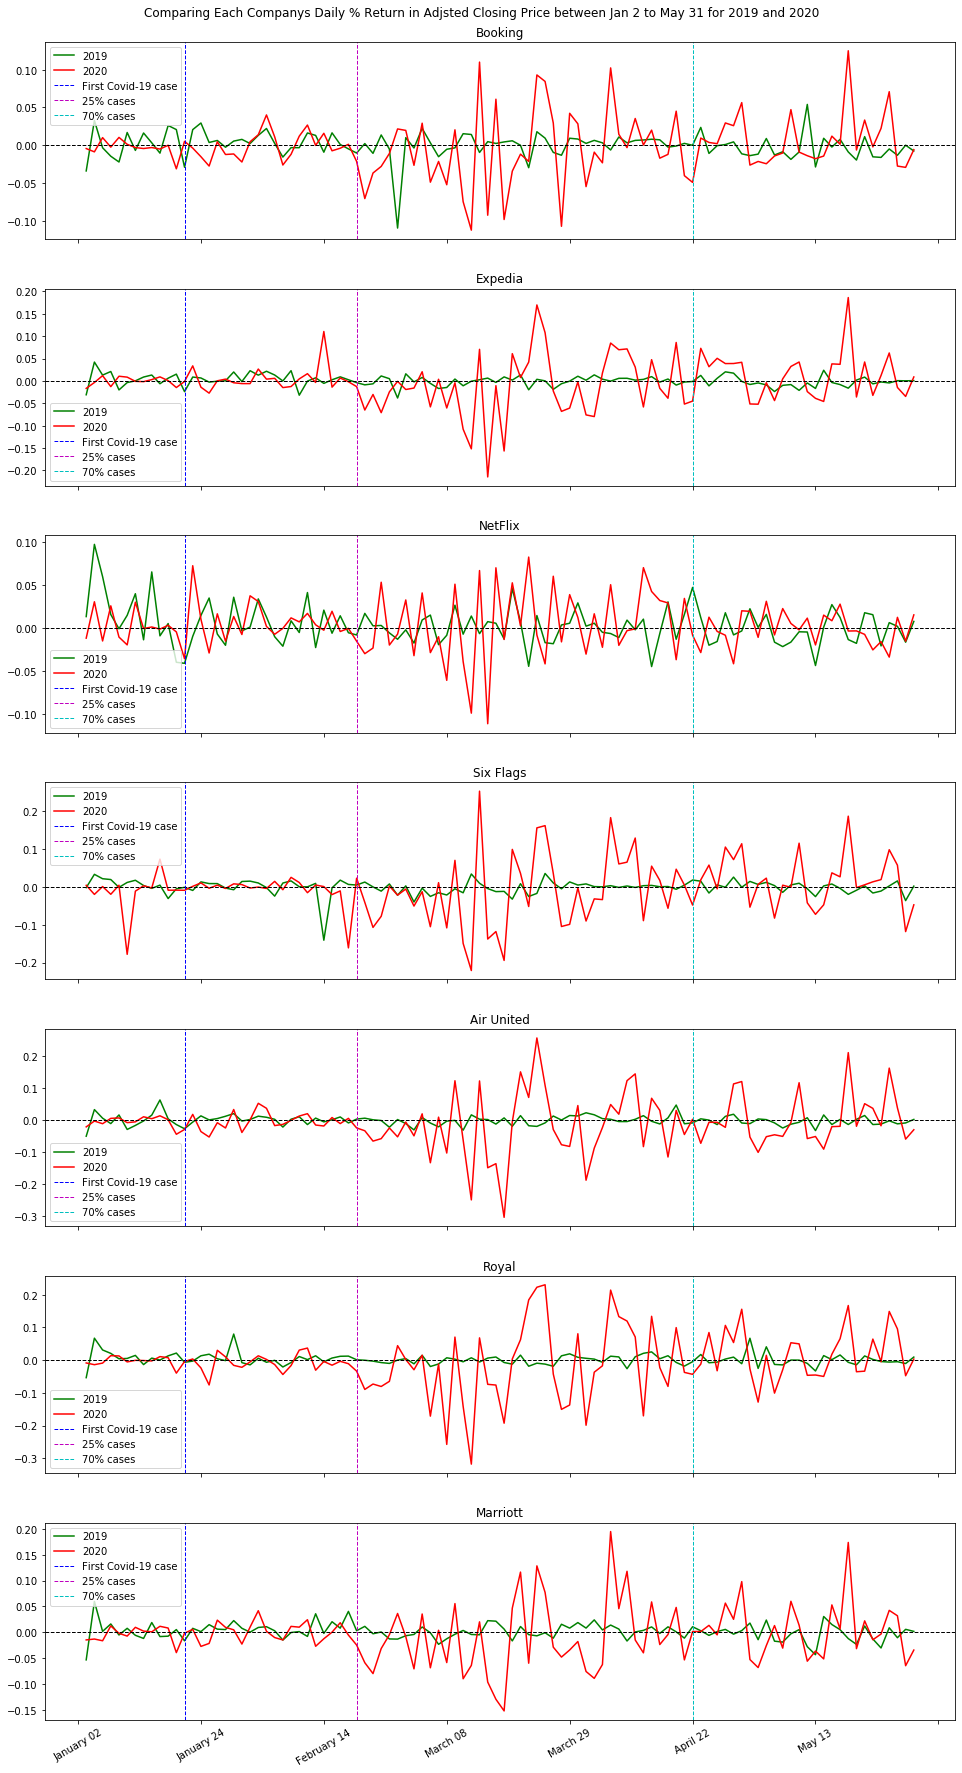

In [239]:
fig, axs = plt.subplots(7, sharex=True, figsize=(14,25))

def add_stock_plot(index, df1,df2, label1, label2 , color1,color2 , title ):
    """
     Add the stock to the plot
    """
    axs[index].plot(monthDay_df['MonthDay'], df1['Return'], label = label1, color= color1)
    axs[index].plot(df2['Return'] , label = label2, color= color2)
    axs[index].set_title(title)
    axs[index].axhline(linewidth=1,ls='--',color='k')
    axs[index].axvline(x= 'January 22' , linewidth=1,label = 'First Covid-19 case' , ls='--',color='b')
    axs[index].axvline(x= 'February 21' , linewidth=1,label = '25% cases' , ls='--',color='m')
    axs[index].axvline(x= 'April 22' , linewidth=1,label = '70% cases' , ls='--',color='c')
    axs[index].legend()
    
    
add_stock_plot( 0, booking_2019, booking_2020, '2019', '2020', 'g' , 'r', 'Booking' )
add_stock_plot( 1, Expedia_2019, Expedia_2020, '2019', '2020', 'g' , 'r', 'Expedia' )
add_stock_plot( 2, nflx_2019, nflx_2020, '2019', '2020', 'g' , 'r', 'NetFlix' )
add_stock_plot( 3, six_2019, six_2020, '2019', '2020', 'g' , 'r', 'Six Flags' )
add_stock_plot( 4, united_2019, united_2020, '2019', '2020', 'g' , 'r', 'Air United' )
add_stock_plot( 5, royal_2019, royal_2020, '2019', '2020', 'g' , 'r', 'Royal')
add_stock_plot( 6, marriott_2019, marriott_2020, '2019', '2020', 'g' , 'r', 'Marriott' )


# options for x-axis tick(size, alignment, bottom= false for no tick marks etc)
axs[6].xaxis.set_major_locator(plt.MaxNLocator(11))
axs[6].tick_params(axis = 'x', rotation = 30 )

# to create space between each subplot
fig.tight_layout(pad=3.0)

fig.suptitle("Comparing Each Companys Daily % Return in Adjsted Closing Price between Jan 2 to May 31 for 2019 and 2020")

def make_space_above(axs, topmargin=1):
    """ increase figure size to make topmargin (in inches) space for 
        titles, without changing the axes sizes
    """
    fig = axs.flatten()[0].figure
    s = fig.subplotpars
    w, h = fig.get_size_inches()

    figh = h - (1-s.top)*h  + topmargin
    fig.subplots_adjust(bottom=s.bottom*h/figh, top=1-topmargin/figh)
    fig.set_figheight(figh)
    
make_space_above(axs, topmargin=1) 

fig.savefig('images/Stocks.png')

As we can see from the line graph of the Daily % Return in Adjusted Closing Price of each stock, the lowest return  happened between Feb 21 where the COVID-19 confirmed cases started to incread by 25% and April 22 when the confirmed cases reached 70%. 

## a) closing price 
The profit or loss calculation is usually determined by the closing price of a stock for the day, hence we will consider the closing price as the target variable. Let’s plot the target variable to understand how it’s shaping up in our data:

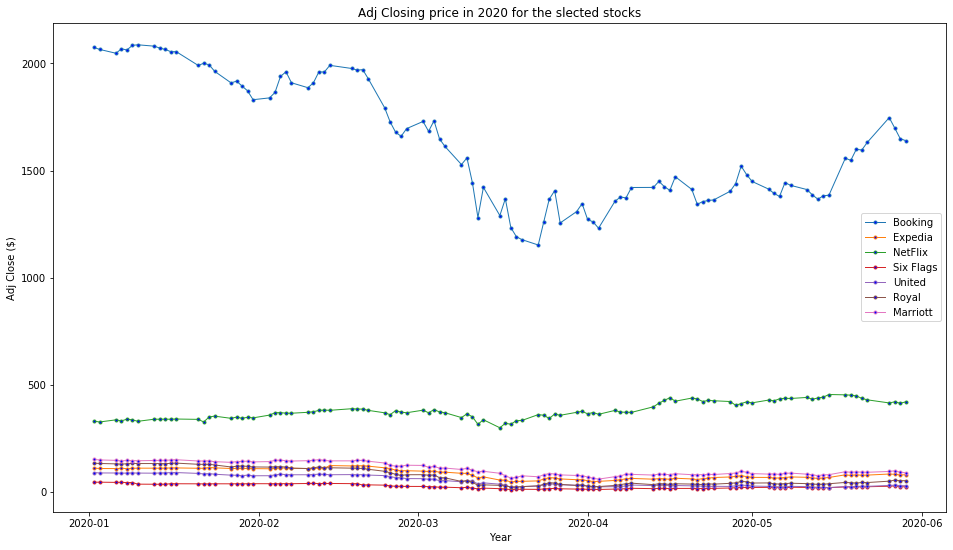

In [240]:
plt.figure(figsize=(16,9))
plt.title("Adj Closing price in 2020 for the slected stocks")
plt.xlabel('Year')
plt.ylabel('Adj Close ($)')
plt.plot( 'Date', 'Adj Close', data=booking_2020, marker='o', markerfacecolor='blue', markersize=3, linewidth=1 , label="Booking")
plt.plot( 'Date', 'Adj Close', data=Expedia_2020, marker='o', markerfacecolor='blue', markersize=3, linewidth=1 , label="Expedia")
plt.plot( 'Date', 'Adj Close', data=nflx_2020, marker='o', markerfacecolor='blue', markersize=3, linewidth=1 , label="NetFlix")
plt.plot( 'Date', 'Adj Close', data=six_2020, marker='o', markerfacecolor='blue', markersize=3, linewidth=1 , label="Six Flags")
plt.plot( 'Date', 'Adj Close', data=united_2020, marker='o', markerfacecolor='blue',markersize=3, linewidth=1,  label="United")
plt.plot( 'Date', 'Adj Close', data=royal_2020, marker='o', markerfacecolor='blue',markersize=3, linewidth=1,  label="Royal")
plt.plot( 'Date', 'Adj Close', data=marriott_2020, marker='o', markerfacecolor='blue',markersize=3, linewidth=1,  label="Marriott")
plt.legend()


As we can see from the line graph the adjusted Closing price in 2020 for the slected stocks, the lowest prices is during March 
Min Adj price for Bookin in 2019 vs 2020: 1649.489990234375 : 1152.239990234375
Min Adj price for NetFlix in 2019 vs 2020: 267.6600036621094 : 298.8399963378906
Min Adj price for Six Flags in 2019 vs 2020: 44.07891845703125 : 10.35999965667724
Min Adj price for United in 2019 vs 2020: 77.48999786376953 : 19.920000076293945
Min Adj price for Royal in 2019 vs 2020: 89.40419006347656 : 22.329999923706055
Min Adj price for Marriott in 2019 vs 2020: 99.90206146240234 : 59.08000183105469


## b) Volume Traded 
Stock trading volume refers to the amount of shares traded in a particular stock over a period of time. Often volume is measured in terms of shares traded per day. Remember that the number of shares bought and sold.<br>
If there's a higher volume of trading in a particular stock, that naturally means that investors are interested in buying or selling it. If volume and price are on the rise, it means investors are betting the company will do well. If volume is up but price is down, it means more investors are looking to sell.

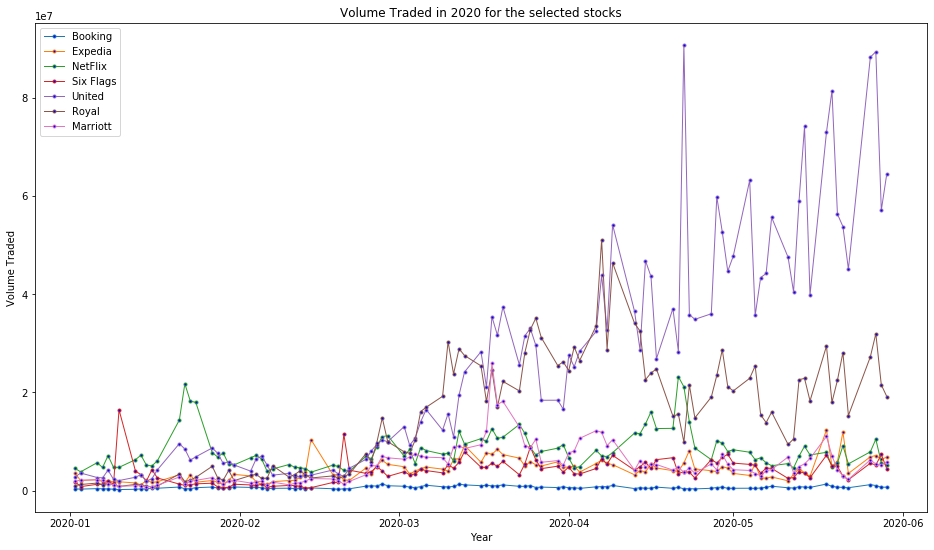

In [241]:
plt.figure(figsize=(16,9))
plt.title("Volume Traded in 2020 for the selected stocks")
plt.xlabel('Year')
plt.ylabel('Volume Traded')
plt.plot( 'Date', 'Volume', data=booking_2020, marker='o', markerfacecolor='blue', markersize=3, linewidth=1 , label="Booking")
plt.plot( 'Date', 'Volume', data=Expedia_2020, marker='o', markerfacecolor='blue', markersize=3, linewidth=1 , label="Expedia")
plt.plot( 'Date', 'Volume', data=nflx_2020, marker='o', markerfacecolor='blue', markersize=3, linewidth=1 , label="NetFlix")
plt.plot( 'Date', 'Volume', data=six_2020, marker='o', markerfacecolor='blue', markersize=3, linewidth=1 , label="Six Flags")
plt.plot( 'Date', 'Volume', data=united_2020, marker='o', markerfacecolor='blue',markersize=3, linewidth=1,  label="United")
plt.plot( 'Date', 'Volume', data=royal_2020, marker='o', markerfacecolor='blue',markersize=3, linewidth=1,  label="Royal")
plt.plot( 'Date', 'Volume', data=marriott_2020, marker='o', markerfacecolor='blue',markersize=3, linewidth=1,  label="Marriott")
plt.legend()

### b) Correlation Matrix Code
Creating correlation matrix between stock prices for all selected companies in 2020 with confirmed covid19 caes

In [279]:
def Correl_Matrix(stock_2020):
    # Correlation Matrix
    stock_covid = pd.merge(stock_2020, df_covid, how='inner', on = 'Date')
# keep only used column
    stock_covid.drop(columns=['Open', 'High', 'Low', 'Close'], inplace=True)
    # Look  at Correlation between variables
    df_corr = stock_covid.corr()
# Get review_scores_rating corr
    df_corr['Adj Close'].sort_values(ascending=False)
    corr = (df_corr)
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.heatmap(corr, xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, linewidths=.5, ax=ax, annot=True)

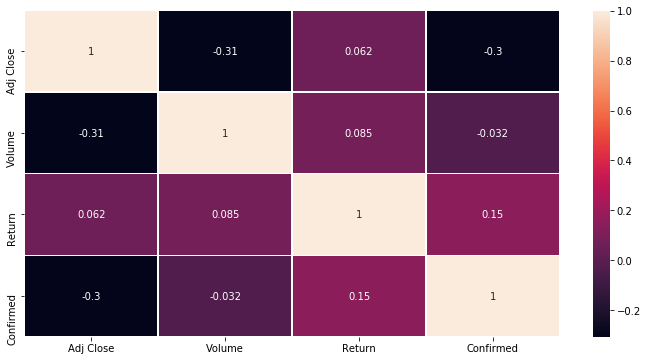

In [280]:
Correl_Matrix(booking_2020)

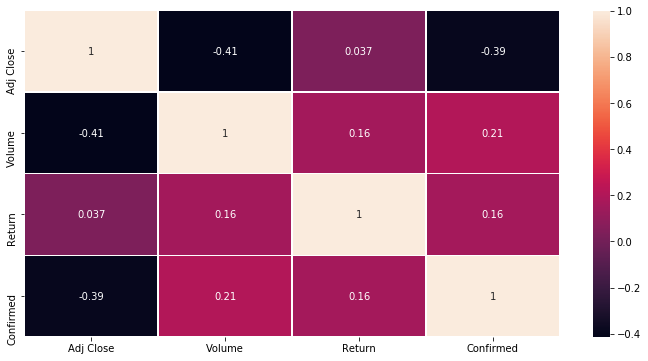

In [281]:
Correl_Matrix(Expedia_2020)

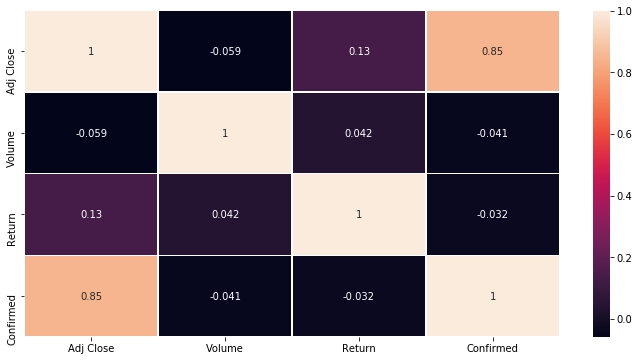

In [282]:
Correl_Matrix(nflx_2020)

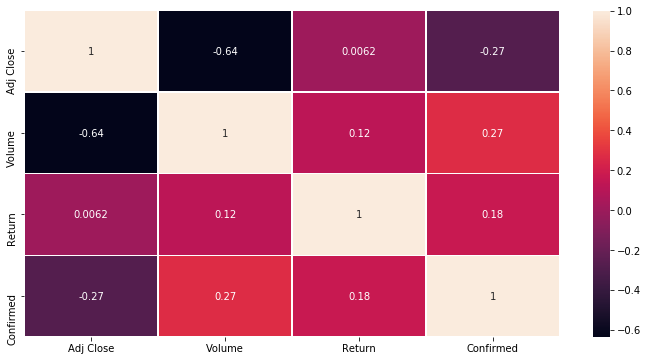

In [283]:
Correl_Matrix(six_2020)

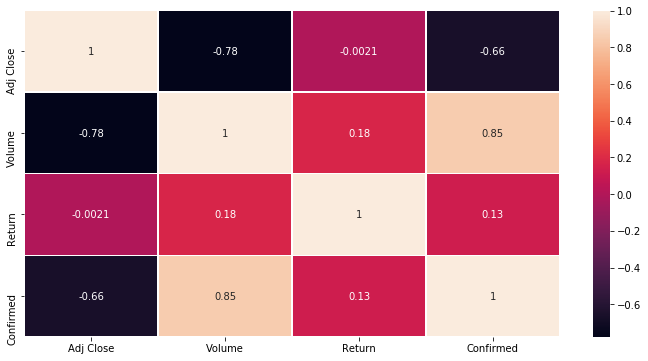

In [284]:
Correl_Matrix(united_2020)

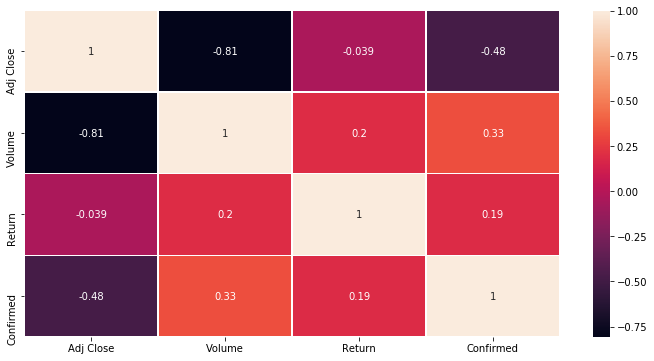

In [285]:
Correl_Matrix(royal_2020)

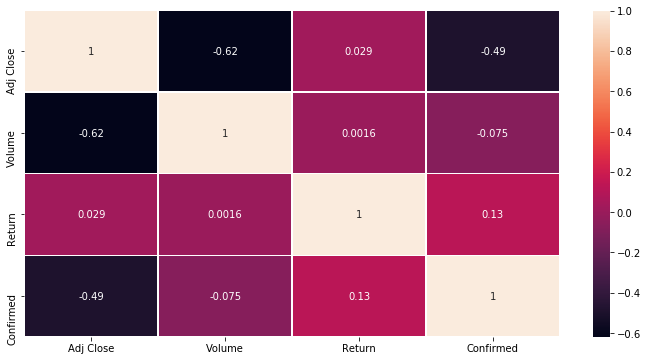

In [286]:
Correl_Matrix(marriott_2020)

Evaluate the correlation coefficient of COVID-19 with the selected BEACH stock market. 
The obtained correlation coefficient presents the intensity and severity of its
impact on the selected stocks. Also, elongated lockdown is further wrecking its condition.

# Part(2) - Stock Predictor with LSTM and Dash 

### 1) Data Visualizing

### a) closing price
The profit or loss calculation is usually determined by the closing price of a stock for the day, hence we will consider the closing price as the target variable. Let’s plot the target variable to understand how it’s shaping up in our data:

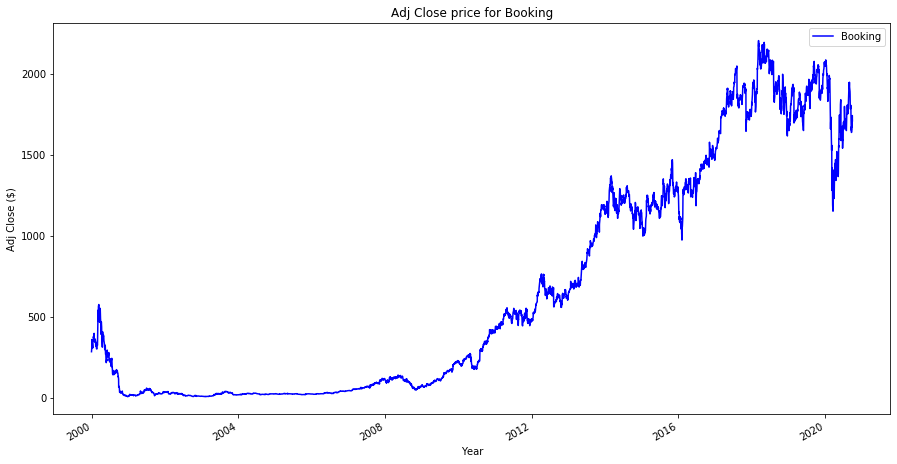

In [117]:
ax = booking_hist.plot(x='Date', y='Adj Close', title='Adj Close price for Booking', figsize=(15, 8), color='blue')
ax.set_xlabel('Year')
ax.set_ylabel('Adj Close ($)')
ax.legend(['Booking'])
plt.show()


### b) Daily Volume
Stock trading volume refers to the amount of shares traded in a particular stock over a period of time. Often volume is measured in terms of shares traded per day. Remember that the number of shares bought and sold.
If there's a higher volume of trading in a particular stock, that naturally means that investors are interested in buying or selling it. If volume and price are on the rise, it means investors are betting the company will do well. If volume is up but price is down, it means more investors are looking to sell.

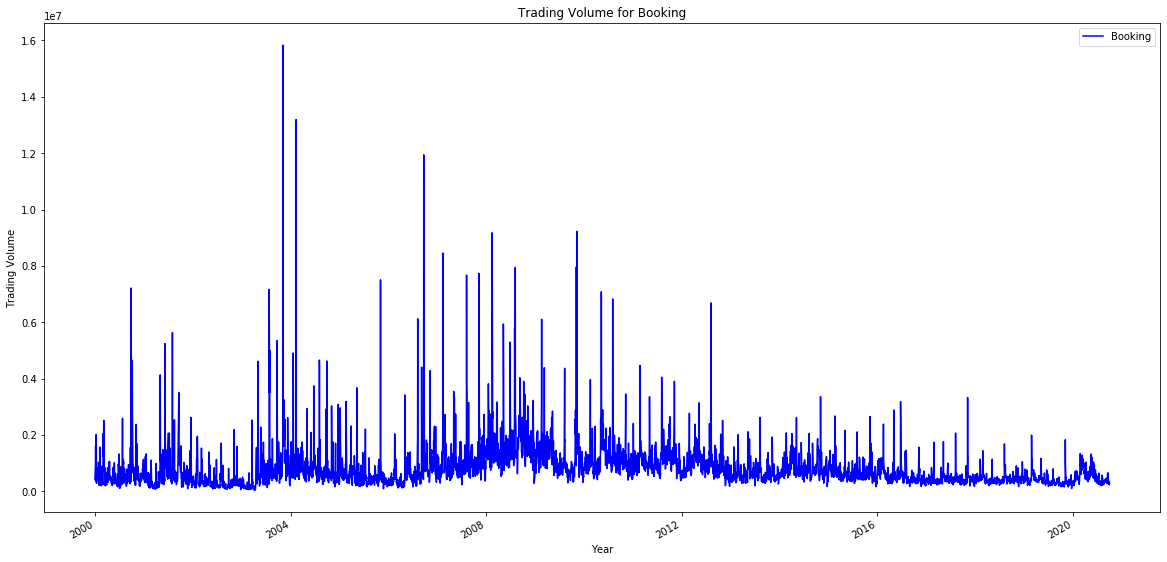

In [109]:
ax = booking_hist.plot(x='Date', y='Volume', title='Trading Volume for Booking', figsize=(20, 10), color='blue')
ax.set_xlabel('Year')
ax.set_ylabel('Trading Volume')
ax.legend(['Booking'])
plt.show()


This graph already says a lot of things. The specific reason I picked this company over others is that this graph is bursting with different behaviors of stock prices over time. This will make the learning more robust as well as give you a change to test how good the predictions are for a variety of situations.

Another thing to notice is that the values close to 2012 are much higher and fluctuate more than the values close to the 2009. 

In [133]:
booking_hist[booking_hist['Volume'] == booking_hist['Volume'].max()]

,Date,Open,High,Low,Close,Adj Close,Volume
966,2003-11-05,22.389999,22.77,21.559999,21.66,21.66,15836100


### (2) Data Preprocessing

In [111]:
booking_df = booking_hist.copy(deep=True)

In [112]:
# keep only used column
booking_df.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume'], inplace=True)

### a) Normalizing the Data
we need to define a scaler to normalize the data. MinMaxScalar scales all the data to be in the region of 0 and 1. 

In [134]:
sc = MinMaxScaler(feature_range=(0.01,0.99))
booking_df['Scaled_Close'] = sc.fit_transform(booking_df[['Adj Close']])

In [135]:
booking_df.head()

,Date,Adj Close,Scaled_Close
0,1999-12-31,284.250,0.133709
1,2000-01-03,307.500,0.144068
2,2000-01-04,324.000,0.151420
3,2000-01-05,359.625,0.167293
4,2000-01-06,345.000,0.160777


### 3- Data Modeling 

In [136]:
n = booking_df.shape[0]
n

5223

### a) Splitting Data into a Training set and a Test set

The ‘num_periods’ is prediction periods that we will test, and compare the results to the benchmark model. The ‘forcast_days’ is defined as how manys we want to forecast based on historical data. The ‘lookback_days’ will be used for the LSTM model as the input feature shape, and the ‘window_size’ is the parameter for the Simple Moving Average benchmark model.

In [179]:
# we will test/validate on 40 periods (40x7=280 days)
num_periods = 40
forcast_days = 7
lookback_days = 15
window_size  = 15

In [180]:
#Define the model training and test set
#test data 40 periods (40x7=280 days)
n_test = num_periods*forcast_days 
# rest is train data
n_train = n - n_test

In [181]:
# count of test data values 
n_test

280

In [182]:
# count of train data values 
n_train

4943

In [183]:
dataset_train , dataset_test = train_test_split(booking_df, train_size=n_train, test_size=n_test, shuffle=False)

In [184]:
#We can then split the data as below. The result train and test sets will have three columns. 
#Beside, for the test dataset, we will need to create an extended dataset, so that it will contain some 
#previous prices, for the purpose of feature creation and moving average price calculation.

dataset_test_extend = dataset_train[-lookback_days:].append(dataset_test)
print(dataset_train.shape, dataset_test.shape, dataset_test_extend.shape)

(4943, 3) (280, 3) (295, 3)


In [185]:
train_set = dataset_train[['Scaled_Close']].values
test_set = dataset_test[['Scaled_Close']].values

In [186]:
# extend the test set to add some previous information
test_set_extend = dataset_test_extend[['Scaled_Close']].values
print(train_set.shape, test_set.shape, test_set_extend.shape)

(4943, 1) (280, 1) (295, 1)


In [187]:
dataset_test.head()

,Date,Adj Close,Scaled_Close
4943,2019-08-26,1916.810059,0.861109
4944,2019-08-27,1919.989990,0.862526
4945,2019-08-28,1942.000000,0.872333
4946,2019-08-29,1957.140015,0.879078
4947,2019-08-30,1966.410034,0.883209


In [188]:
dataset_train.head()

,Date,Adj Close,Scaled_Close
0,1999-12-31,284.250,0.133709
1,2000-01-03,307.500,0.144068
2,2000-01-04,324.000,0.151420
3,2000-01-05,359.625,0.167293
4,2000-01-06,345.000,0.160777


## b) Model implementation - Long Short Term Memory (LSTM)
LSTMs are widely used for sequence prediction problems and have proven to be extremely effective. The reason they work so well is because LSTM is able to store past information that is important, and forget the information that is not. LSTM has three gates:


In [189]:
#Once we have defined our parameters such as ‘lookback_days’, ‘forcast_days’, and have our train and test datasets. 
#The next step is to generate the sequence for the LSTM model. Below we have the function to do that.

def generate_train_test_sequence(t_data, lookback_days, forcast_days, sequence, last_index):
    """
    Generate sequence array for train data, test data
    inclduing both X and y
    """
    X = []
    y = []
    m = lookback_days
    n =forcast_days
    N = len(t_data)
 
    # train sequence is continuous = 1 
    # test sequence is not continuous, will be in 20 groups, each group contains 7 days

    for i in range(0, N, sequence):
        # input sequence : x[i].....x[i+m]
        # output sequence: x[i+m+1]....x[i+m+n] 
        # last index is (i+m+n)
        end_index = i + m + n # find the end of this sequence
        # check if we are out of index
        if end_index > N-last_index:
            break
        seq_x = t_data[i:(i+m)]
        seq_y = t_data[(i+m):(i+m+n)]
        X.append(seq_x)
        y.append(seq_y)
        
    array_X = np.array(X) # shape (N, m, 1)
    array_y = np.array([list(a.ravel()) for a in np.array(y)]) # shape (N, n, 1) convert to (N, n)
    return array_X, array_y


In [190]:
# train sequence is continuous
X_train, y_train = generate_train_test_sequence(train_set, lookback_days, forcast_days, 1, 1)
print(X_train.shape, y_train.shape)

(4921, 15, 1) (4921, 7)


In [191]:
def generate_train_test_sequence(t_data, lookback_days, forcast_days, sequence, last_index):
    """
    Generate sequence array for train data, test data
    inclduing both X and y
    """
    X = []
    y = []
    m = lookback_days
    n =forcast_days
    N = len(t_data)
 
    # train sequence is continuous = 1 
    # test sequence is not continuous, will be in 20 groups, each group contains 7 days

    for i in range(0, N, sequence):
        # input sequence : x[i].....x[i+m]
        # output sequence: x[i+m+1]....x[i+m+n] 
        # last index is (i+m+n)
        end_index = i + m + n # find the end of this sequence
        # check if we are out of index
        if end_index > N-last_index:
            break
        seq_x = t_data[i:(i+m)]
        seq_y = t_data[(i+m):(i+m+n)]
        X.append(seq_x)
        y.append(seq_y)
        
    array_X = np.array(X) # shape (N, m, 1)
    array_y = np.array([list(a.ravel()) for a in np.array(y)]) # shape (N, n, 1) convert to (N, n)
    return array_X, array_y
# train sequence is continuous
X_train, y_train = generate_train_test_sequence(train_set, lookback_days, forcast_days, 1, 1)
print(X_train.shape, y_train.shape)

print(X_train[0])
print(' ')
print(y_train[0])


(4921, 15, 1) (4921, 7)
[[0.13370913]
 [0.14406835]
 [0.15142005]
 [0.16729305]
 [0.16077676]
 [0.16010843]
 [0.15208839]
 [0.14824545]
 [0.14373418]
 [0.14507085]
 [0.15910592]
 [0.16528804]
 [0.17397642]
 [0.17263974]
 [0.17681685]]
 
[0.16729305 0.17531309 0.18416855 0.17848769 0.16645763 0.16211344
 0.16010843]


Since the training data is only 5223 points, I will just use a simple LSTM model, instead of a complicated model (which will be two or more layers). The loss function of the LSTM will be `mean_squared_error’, and the activation function I will choose ‘relu’. The input data shape, as expected, will be (lookback_days, 1). The model function is as below. 

In [192]:
model = Sequential()
model.add(LSTM(units=30, activation='relu', input_shape=(lookback_days,1)))
model.add(Dense(forcast_days))
model.compile(optimizer='adam', loss='mean_squared_error')

In [193]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30)                3840      
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 217       
Total params: 4,057
Trainable params: 4,057
Non-trainable params: 0
_________________________________________________________________


In [194]:
num_epochs = 300
history  = model.fit(X_train,y_train,epochs=num_epochs,batch_size=32)


Epoch 1/300
154/154 [==============================] - 1s 6ms/step - loss: 0.0242
Epoch 2/300
154/154 [==============================] - 1s 5ms/step - loss: 5.3013e-04
Epoch 3/300
154/154 [==============================] - 1s 5ms/step - loss: 3.8798e-04A: 0s - loss: 4
Epoch 4/300
154/154 [==============================] - 1s 5ms/step - loss: 3.6807e-04
Epoch 5/300
154/154 [==============================] - 1s 6ms/step - loss: 3.4788e-04
Epoch 6/300
154/154 [==============================] - 1s 5ms/step - loss: 3.5210e-04
Epoch 7/300
154/154 [==============================] - 1s 5ms/step - loss: 3.3222e-04
Epoch 8/300
154/154 [==============================] - 1s 6ms/step - loss: 3.3753e-04
Epoch 9/300
154/154 [==============================] - 1s 6ms/step - loss: 3.1540e-04
Epoch 10/300
154/154 [==============================] - 1s 6ms/step - loss: 3.2517e-04
Epoch 11/300
154/154 [==============================] - 1s 5ms/step - loss: 3.0766e-04
Epoch 12/300
154/154 [===================

154/154 [==============================] - 1s 5ms/step - loss: 2.0254e-04
Epoch 95/300
154/154 [==============================] - 1s 6ms/step - loss: 2.0776e-04
Epoch 96/300
154/154 [==============================] - 1s 6ms/step - loss: 2.0729e-04
Epoch 97/300
154/154 [==============================] - 1s 5ms/step - loss: 2.0197e-04
Epoch 98/300
154/154 [==============================] - 1s 5ms/step - loss: 2.0306e-04
Epoch 99/300
154/154 [==============================] - 1s 5ms/step - loss: 1.9808e-04
Epoch 100/300
154/154 [==============================] - 1s 5ms/step - loss: 2.0274e-04
Epoch 101/300
154/154 [==============================] - 1s 5ms/step - loss: 2.0571e-04
Epoch 102/300
154/154 [==============================] - 1s 6ms/step - loss: 2.0759e-04
Epoch 103/300
154/154 [==============================] - 1s 6ms/step - loss: 2.1028e-04
Epoch 104/300
154/154 [==============================] - 1s 5ms/step - loss: 2.0354e-04
Epoch 105/300
154/154 [============================

154/154 [==============================] - 1s 5ms/step - loss: 1.9418e-04
Epoch 188/300
154/154 [==============================] - 1s 5ms/step - loss: 1.9790e-04
Epoch 189/300
154/154 [==============================] - 1s 6ms/step - loss: 1.9974e-04
Epoch 190/300
154/154 [==============================] - 1s 6ms/step - loss: 2.0868e-04
Epoch 191/300
154/154 [==============================] - 1s 6ms/step - loss: 1.9745e-04
Epoch 192/300
154/154 [==============================] - 1s 6ms/step - loss: 1.9293e-04
Epoch 193/300
154/154 [==============================] - 1s 6ms/step - loss: 1.9429e-04
Epoch 194/300
154/154 [==============================] - 1s 6ms/step - loss: 1.9441e-04
Epoch 195/300
154/154 [==============================] - 1s 7ms/step - loss: 1.9078e-04
Epoch 196/300
154/154 [==============================] - 1s 6ms/step - loss: 1.9662e-04
Epoch 197/300
154/154 [==============================] - 1s 6ms/step - loss: 1.9738e-04
Epoch 198/300
154/154 [=======================

154/154 [==============================] - 1s 5ms/step - loss: 1.9158e-04
Epoch 280/300
154/154 [==============================] - 1s 5ms/step - loss: 1.8977e-04
Epoch 281/300
154/154 [==============================] - 1s 5ms/step - loss: 1.8986e-04
Epoch 282/300
154/154 [==============================] - 1s 5ms/step - loss: 1.9186e-04
Epoch 283/300
154/154 [==============================] - 1s 5ms/step - loss: 1.9649e-04
Epoch 284/300
154/154 [==============================] - 1s 5ms/step - loss: 1.9348e-04
Epoch 285/300
154/154 [==============================] - 1s 5ms/step - loss: 1.9324e-04
Epoch 286/300
154/154 [==============================] - 1s 5ms/step - loss: 1.9000e-04
Epoch 287/300
154/154 [==============================] - 1s 5ms/step - loss: 1.9145e-04
Epoch 288/300
154/154 [==============================] - 1s 5ms/step - loss: 1.9218e-04
Epoch 289/300
154/154 [==============================] - 1s 5ms/step - loss: 1.9031e-04
Epoch 290/300
154/154 [=======================

## Visualize the training data

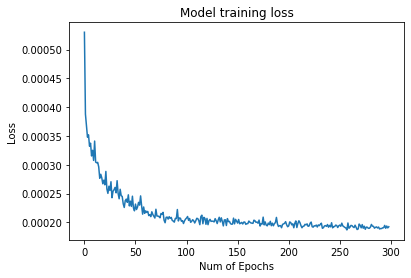

In [195]:
plt.figure()
plt.plot(history.history['loss'][1:])
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Num of Epochs')
plt.show()


## Prediction on the test set with LSTM

In [196]:
# test sequence is not continuous, will be in 20 groups, each group contains 7 days
X_test, y_test = generate_train_test_sequence(test_set_extend, lookback_days, forcast_days,forcast_days,0)
print(test_set_extend.shape, X_test.shape, y_test.shape)


(295, 1) (40, 15, 1) (40, 7)


In [197]:
LSTM_prediction_scaled = model.predict(X_test)
LSTM_prediction = sc.inverse_transform(LSTM_prediction_scaled)

train_set = train_set.reshape((-1))
test_set = test_set.reshape((-1))
LSTM_prediction = LSTM_prediction.reshape((-1))


In [199]:
dataset_test['LSTM_Prediction'] = LSTM_prediction
dataset_test.head()

,Date,Adj Close,Scaled_Close,LSTM_Prediction
4943,2019-08-26,1916.810059,0.861109,1880.174561
4944,2019-08-27,1919.989990,0.862526,1889.030396
4945,2019-08-28,1942.000000,0.872333,1878.846802
4946,2019-08-29,1957.140015,0.879078,1885.351685
4947,2019-08-30,1966.410034,0.883209,1876.185791


In [200]:
def plot_prediction_comparison(true_set, prediction_set):
    plt.figure(figsize = (15,8))

    for i in range(0, len(prediction_set), forcast_days):
        indexs = [i+x for x in range(forcast_days)]
        values = prediction_set[i:i+forcast_days]
        plt.plot(indexs, values, color='r')

    plt.plot(0, prediction_set[0], color='r', label='prediction') # just used to add label

    plt.plot(true_set, color='b', label='True Close')
    plt.legend(loc='best')
    plt.show()


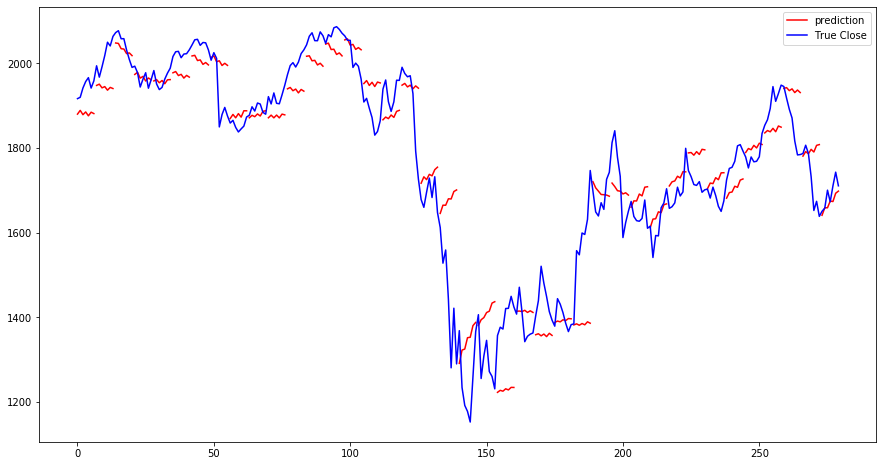

In [201]:
plot_prediction_comparison(dataset_test['Adj Close'].values, dataset_test['LSTM_Prediction'].values)

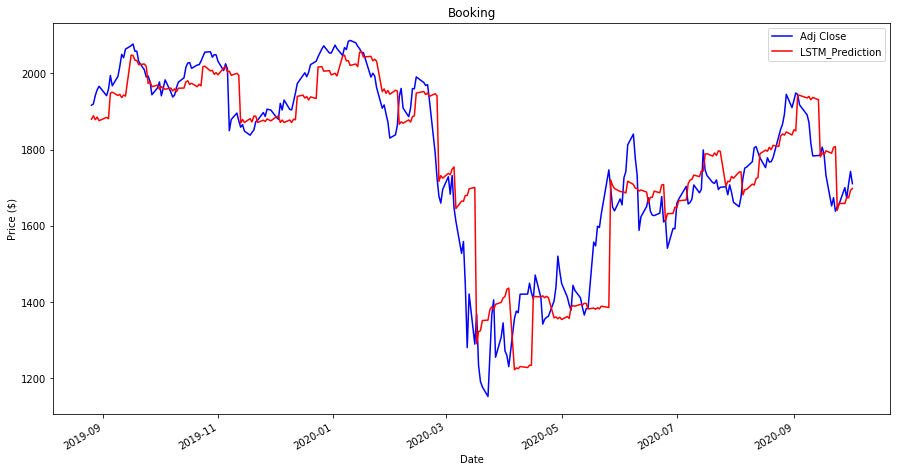

In [202]:
ax = dataset_test.plot(x='Date', y=["Adj Close", "LSTM_Prediction"], 
                       title='Booking', figsize=(15, 8), color=['blue', 'red'])

ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')
plt.show()


## Moving Average

In [203]:
dataset_test_extend['MA_Prediction'] = np.NaN

In [204]:
def make_window(size, start):
    # make index window for use of concat of real price and prediction price
    return [start+k for k in range(size)]


In [205]:
for index in range(window_size, len(dataset_test_extend), forcast_days):
    for i in range(0,forcast_days):
        if index+i >= len(dataset_test_extend):
            break
        # window for real price, eg [1, 2, 3, 4, 5, 6, 7, 8, 9]
        window_real = make_window(window_size-i, index+i-window_size)
        
        # window for predicted price, eg [10]
        window_MA = make_window(i, index)

        price_window = pd.concat([ dataset_test_extend['Adj Close'].iloc[window_real], 
                                   dataset_test_extend['MA_Prediction'].iloc[window_MA] ])
        next_mean_prediction = price_window.mean(axis=0)

        dataset_test_extend.iat[index+i, dataset_test_extend.columns.get_loc('MA_Prediction')] = next_mean_prediction


In [206]:
dataset_test['MA_Prediction'] = dataset_test_extend[lookback_days:]['MA_Prediction'].values
dataset_test.head()


,Date,Adj Close,Scaled_Close,LSTM_Prediction,MA_Prediction
4943,2019-08-26,1916.810059,0.861109,1880.174561,1901.235327
4944,2019-08-27,1919.989990,0.862526,1889.030396,1908.744351
4945,2019-08-28,1942.000000,0.872333,1878.846802,1916.892639
4946,2019-08-29,1957.140015,0.879078,1885.351685,1923.248145
4947,2019-08-30,1966.410034,0.883209,1876.185791,1922.064020


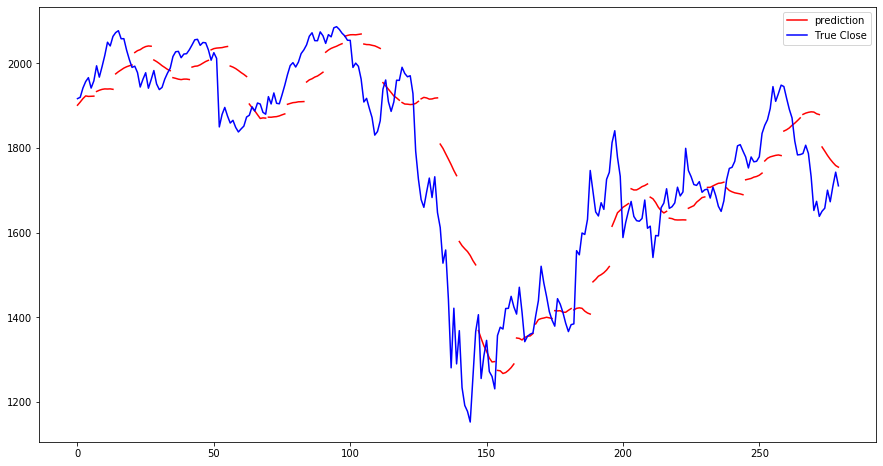

In [207]:
plot_prediction_comparison(dataset_test['Adj Close'].values, dataset_test['MA_Prediction'].values)

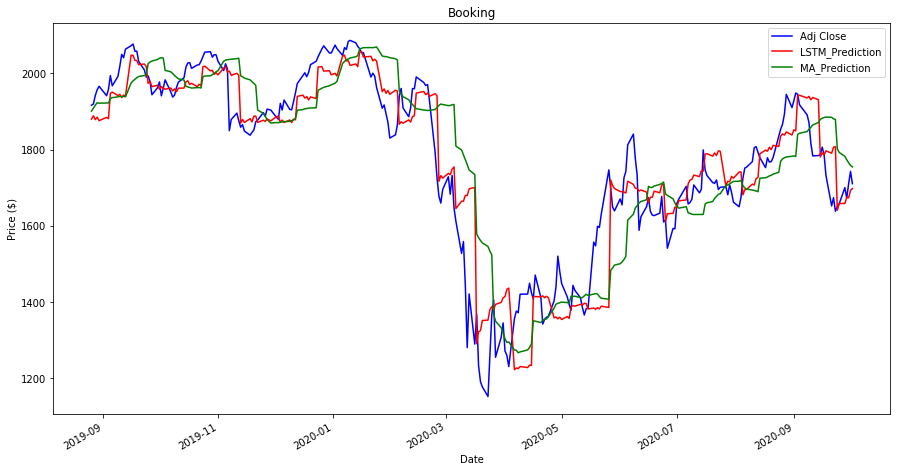

In [208]:
ax = dataset_test.plot(x='Date', y=["Adj Close", "LSTM_Prediction", "MA_Prediction"], 
                       title='Booking', figsize=(15, 8), color=['blue', 'red', 'green'])

ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')
plt.show()


## Evaludate the performance

In [209]:
#The Mean Squared Error (MSE) can be calculated by taking the Squared Error between the true value at one step ahead
#and the predicted value and averaging it over all the predictions.

def evaluate_prediction(y_true, y_pred):
    
    # mean absolute error
    mae = mean_absolute_error(y_true, y_pred)
    
    #mean squared error
    mse = mean_squared_error(y_true, y_pred)
    
    # root mean squared error
    rmse = round(np.sqrt(mse), 2)
    
    # mean absolute percentage error
    mape = round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)
           
    return {'root_mean_squared_error': rmse, 
            'mean_absolute_percentage_error': mape}


In [210]:
y_test = dataset_test['Adj Close']
y_pred_lstm = dataset_test['LSTM_Prediction']
y_pred_ma = dataset_test['MA_Prediction']


In [211]:
# evaluation for LSTM prediction
evaluate_prediction(y_test, y_pred_lstm)


{'root_mean_squared_error': 89.07, 'mean_absolute_percentage_error': 3.92}

In [212]:
# evaluation for Moving Average prediction
evaluate_prediction(y_test, y_pred_ma)

{'root_mean_squared_error': 122.22, 'mean_absolute_percentage_error': 5.5}

## Forcast

In [213]:
booking_df.tail()

,Date,Adj Close,Scaled_Close
5218,2020-09-28,1700.400024,0.764686
5219,2020-09-29,1672.979980,0.752469
5220,2020-09-30,1710.680054,0.769266
5221,2020-10-01,1742.979980,0.783658
5222,2020-10-02,1710.709961,0.769280


In [214]:
def predict_future_price(df, lookback_days, forcast_days, model, sc):
    """
    Prediction of future stock price
    """
    
    # calculate forcast dates and indexs, used for plot
    B_DAY = CustomBusinessDay(calendar=USFederalHolidayCalendar()) # business day
    forcast_dates = [df['Date'].iloc[-1]+i*B_DAY for i in range(1,forcast_days+1)]
    forcast_indexs = [df['Date'].index[-1]+i for i in range(1,forcast_days+1)]
    # input X for forcast
    X_scaled = df[['Scaled_Close']][-lookback_days:].values
    X_scaled = X_scaled.reshape((1, lookback_days, 1))
    
    # prediction the scaled price with model
    forcast_price_scaled = model.predict(X_scaled)
    
    # transform back to the normal price
    forcast_prices = sc.inverse_transform(forcast_price_scaled)
    
    # create the forcast_dataframe
    forcast_dataframe = pd.DataFrame({
        'index' : forcast_indexs,
        'Date' : forcast_dates,
        'Adj Close' : forcast_prices[0],
        'Scaled_Close' : forcast_price_scaled[0]
    })

    forcast_dataframe = forcast_dataframe.set_index('index', drop=True)
    return forcast_dataframe

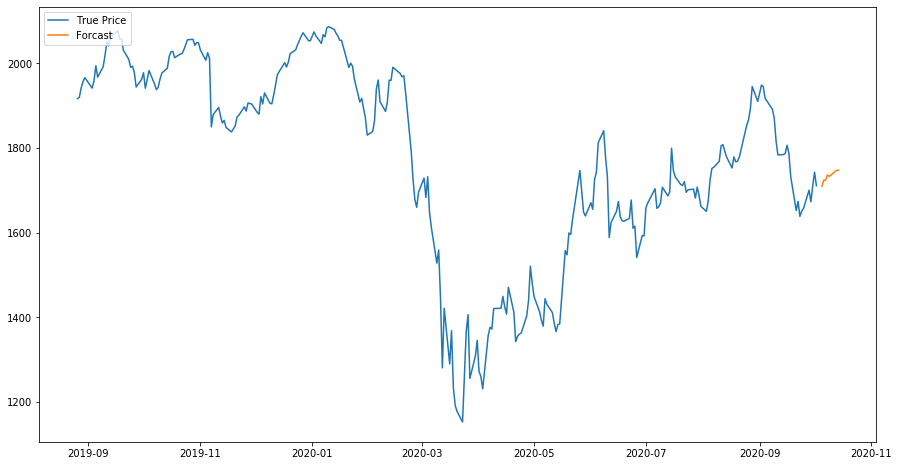

In [215]:
dataset_forcast = predict_future_price(booking_df, lookback_days, forcast_days, model, sc)

dataset_forcast.head()

fig = plt.figure(figsize = (15,8))

for frame in [dataset_test, dataset_forcast]:
    plt.plot(frame['Date'], frame['Adj Close'])

plt.legend(['True Price', 'Forcast'], loc='upper left')
plt.show()